# 20기 Time Series 정규세션 과제

### Electric_Production.csv 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
첨부한 '시계열자료_실습.ipynb' 코드를 참고하셔도 좋습니다.


### Box-Jenkins 방법론
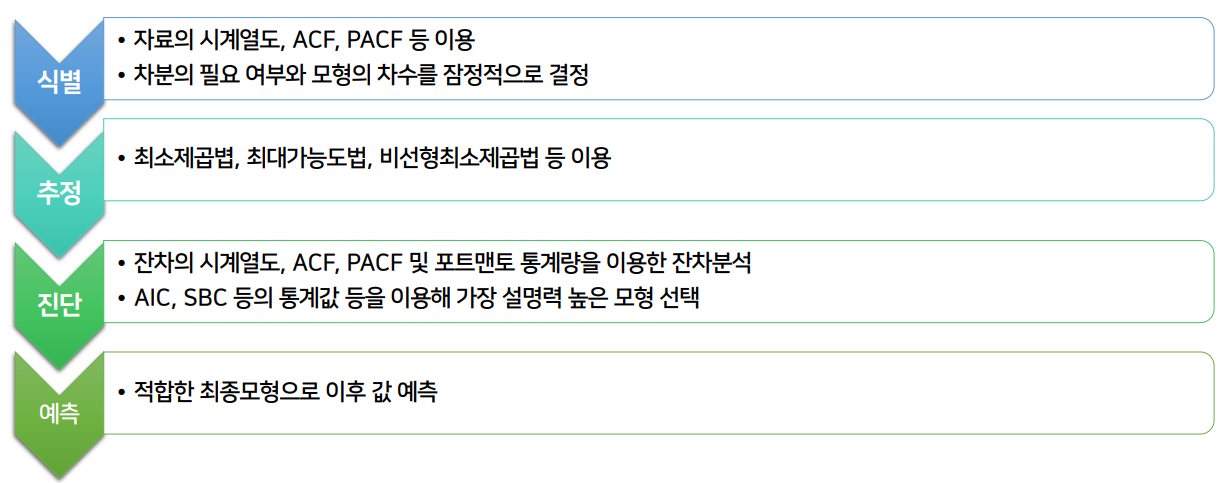

### Prophet
튜토리얼 : https://hyperconnect.github.io/2020/03/09/prophet-package.html

## 라이브러리 불러오기

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from pandas import datetime
from statsmodels.tsa.arima_model import ARIMAResults

import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import itertools

## 데이터 불러오기

In [2]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


# 그래프 그리기

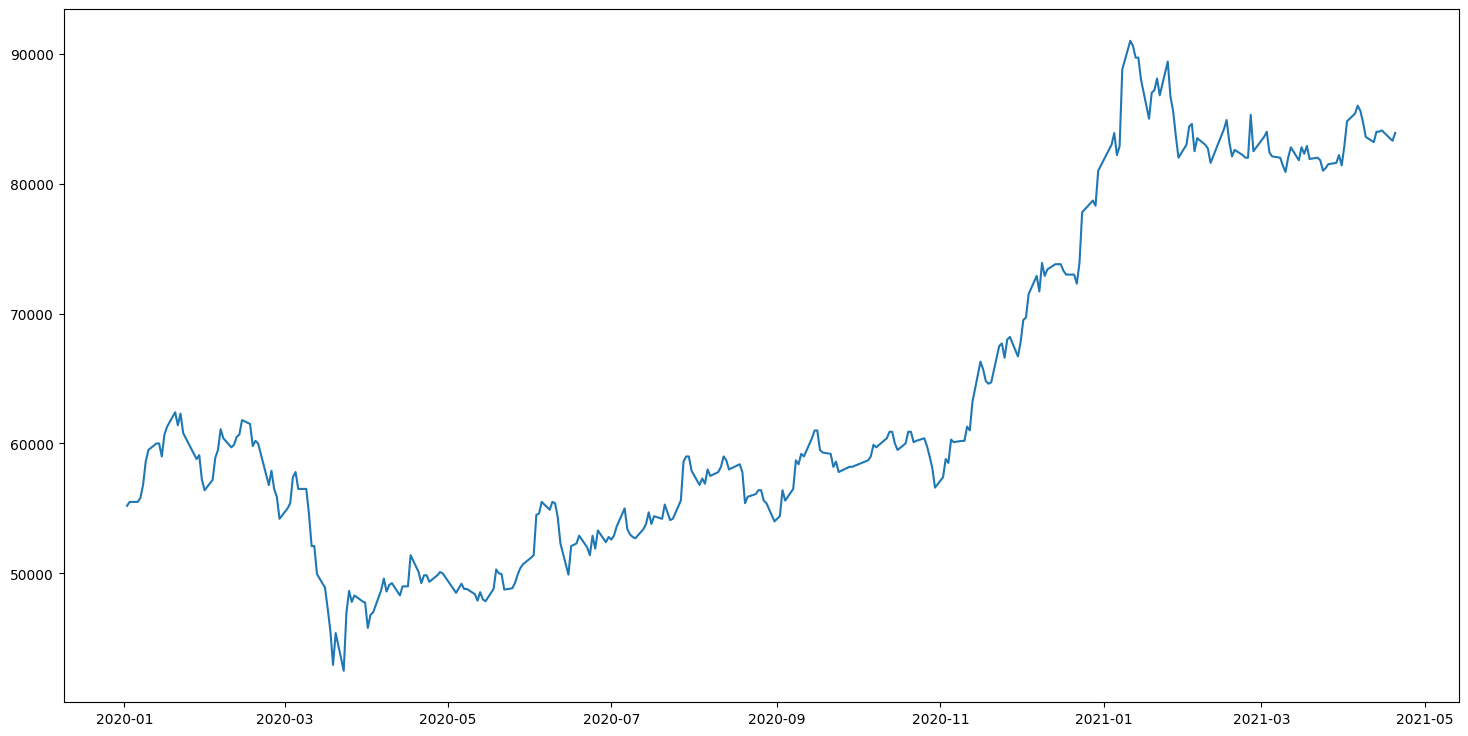

In [3]:
plt.figure(figsize=(18,9))
plt.plot(samsung_df.index,samsung_df["price"], linestyle="-")
plt.xlabel=('day')
plt.ylabel=('price')
plt.show()

# Box-Jenkins ARIMA Procedure
- 1. Data Preprocessing
-  2. Identify Model to be Tentatively Entertainted
-  3. Estimate Check
-  4. Diagnosis Check
-  5. Use Model to Forecast

## 1. Data Preprocessing

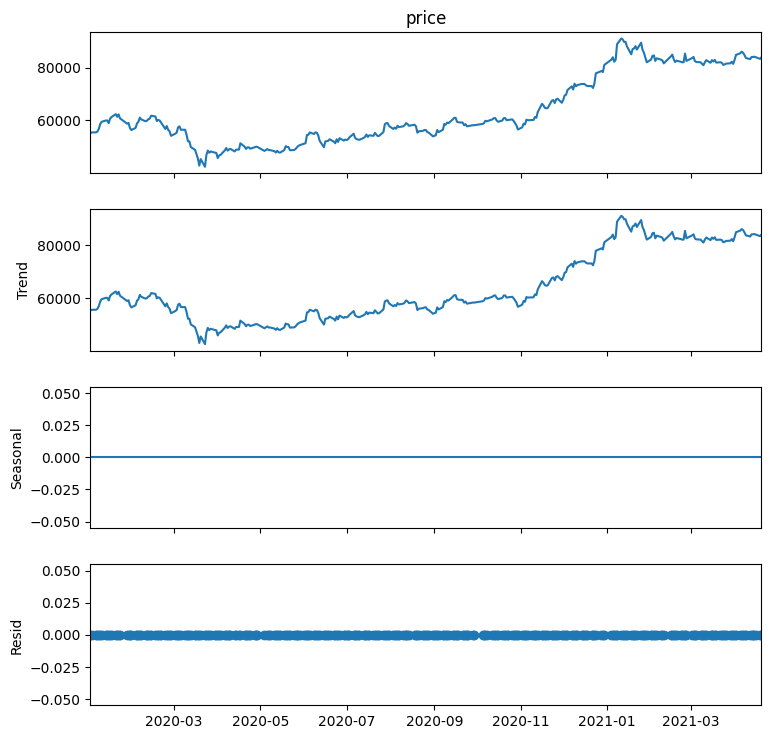

In [4]:
# seasonal_decomosition plot 이용 -> MA 기법 사용
decomposition = sm.tsa.seasonal_decompose(samsung_df['price'], model='add', period=1)

# observed : observed data
# Trend : The estimated trend component
# Seasonal : The estimated seasonal component
# resid = The estimated residuals(잔차)

fig = decomposition.plot()
fig.set_size_inches(8,8)
fig.xlabel=('day')
fig.ylabel=('price')
plt.show()


## 2. Identify Model to be Tentatively Entertainted

In [5]:
# train : test = 7 : 3
train_data, test_data = train_test_split(samsung_df, test_size = 0.3, shuffle = False)

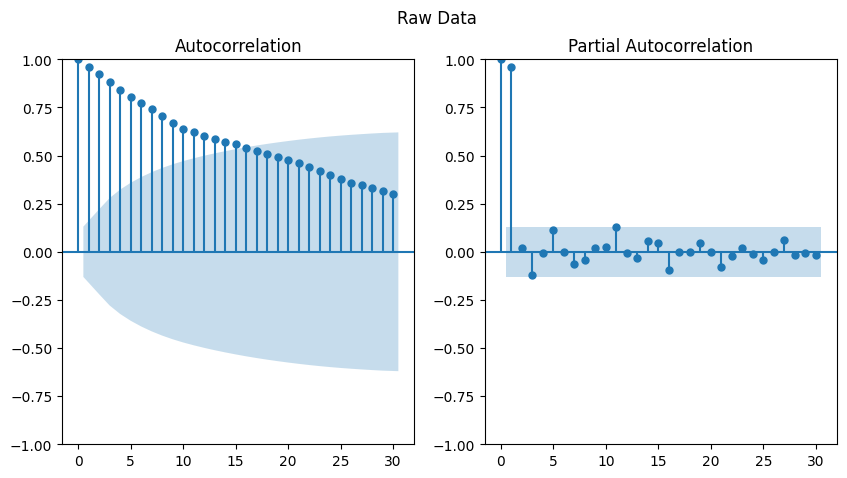

In [6]:
# ACF, PACF plot


fig, ax = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle("Raw Data")
plot_acf(train_data.values.squeeze(), lags = 30, ax=ax[0])
plot_pacf(train_data.values.squeeze(), lags = 30, ax=ax[1]);

* ACF -> Lag 17 이후로 구간 안에 위치하므로 MA(17) 모형으로 잠정모형 채택 
* PACF -> Lag 3 이후로 구간 안에 위치하므로 AR(3) 모형으로 잠정모형 채택

추정 전, 차분 진행

In [7]:
# Differencing

diff_train_data = train_data.copy()
diff_train_data = diff_train_data['price'].diff()
diff_train_data = diff_train_data.dropna() # 마지막 값 결측치에 대한 제거
print("Raw Data")
print(train_data)
print("Differenced Data")
print(diff_train_data)

Raw Data
              price
day                
2020-01-02  55200.0
2020-01-03  55500.0
2020-01-06  55500.0
2020-01-07  55800.0
2020-01-08  56800.0
...             ...
2020-11-20  64700.0
2020-11-23  67500.0
2020-11-24  67700.0
2020-11-25  66600.0
2020-11-26  68000.0

[225 rows x 1 columns]
Differenced Data
day
2020-01-03     300.0
2020-01-06       0.0
2020-01-07     300.0
2020-01-08    1000.0
2020-01-09    1800.0
               ...  
2020-11-20     100.0
2020-11-23    2800.0
2020-11-24     200.0
2020-11-25   -1100.0
2020-11-26    1400.0
Name: price, Length: 224, dtype: float64


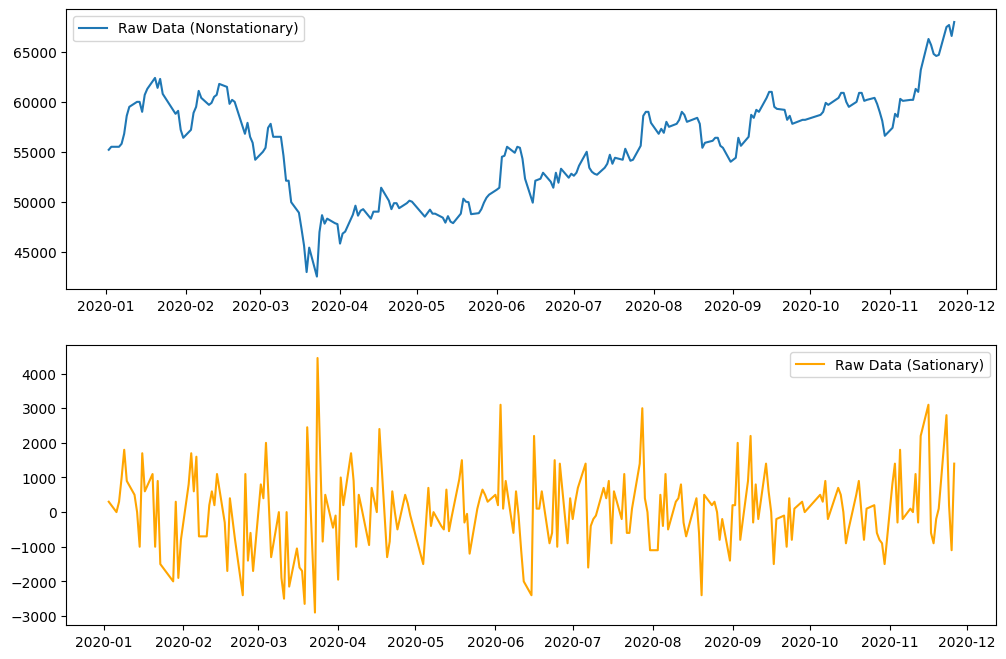

In [8]:
# Differenced data plot

plt.figure(figsize =(12,8))
plt.subplot(211)
plt.plot(train_data['price'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_train_data, 'orange') # 주황색
plt.legend(['Raw Data (Sationary)'])
plt.show()

`시각적으로 1차 차분한 그래프가 이전보다 훨씬 정상성을 띠는 것을 확인할 수 있다.`

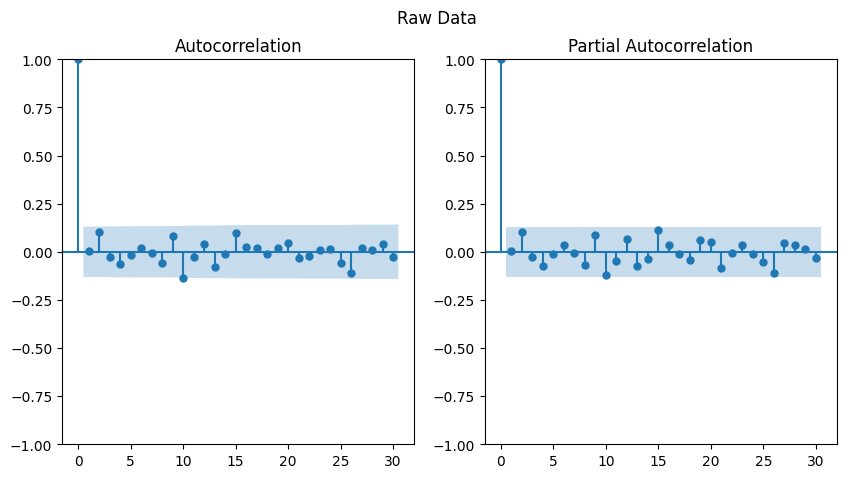

In [9]:
# Dfferenced ACF, PACF plot


fig, ax = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle("Raw Data")
plot_acf(diff_train_data.values.squeeze(), lags = 30, ax=ax[0])
plot_pacf(diff_train_data.values.squeeze(), lags = 30, ax=ax[1]);

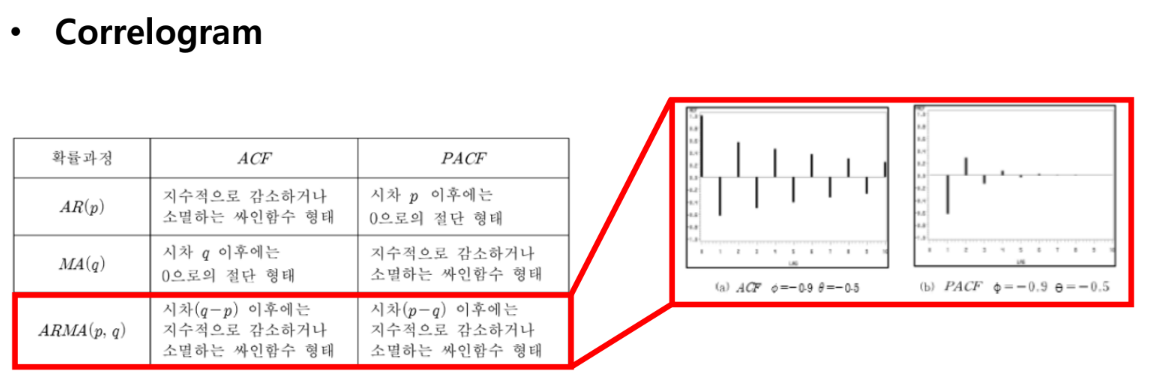

ARIMA 모델에 대해서 p = 2로 설정하여 추정하고자 한다.

## 3.Estimated Parameters

In [10]:
# ARIMA model fitting
# p = 2 , d = 1, q = 0

# error로 인해 SARIMAX 모델 사용, seasonal_order는 제외
model = SARIMAX(train_data.values, order=(2, 1, 0))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  225
Model:               SARIMAX(2, 1, 0)   Log Likelihood               -1891.031
Date:                Sun, 27 Aug 2023   AIC                           3788.062
Time:                        16:50:38   BIC                           3798.297
Sample:                             0   HQIC                          3792.193
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0084      0.051      0.164      0.870      -0.092       0.109
ar.L2          0.0246      0.041      0.595      0.552      -0.056       0.106
sigma2       1.26e+06   1.02e+05     12.319      0.0

* AIC score : 3788.062
* BIC score : 3798.297
* 위에서 p value 값이 너무 크게 나와서 파라미터 값을 조정하고자 한다.
* 더 해서 seasonal에 대한 파라미터 값도 함께 확인하고자 한다.

## 4. Diagnosis Check

In [11]:
# Parameter Search

p = range(0, 3)
d = range(1, 2)
q = range(0, 3)
pdq = list(itertools.product(p,d,q))
seasonal_pdq =[(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

aic = []
params = []
for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX(train_data.values, order=(i), seasonal_order=(j))
            model_fit = model.fit()
            print(f"SARIMA: {i}{j} >> AIC : {round(model_fit.aic, 2)}")
            aic.append(round(model_fit.aic, 2))
            params.append((i,j))
        except:
            continue

SARIMA: (0, 1, 0)(0, 1, 0, 12) >> AIC : 3716.7
SARIMA: (0, 1, 0)(0, 1, 1, 12) >> AIC : 3705.85
SARIMA: (0, 1, 0)(0, 1, 2, 12) >> AIC : 3690.56
SARIMA: (0, 1, 0)(1, 1, 0, 12) >> AIC : 3714.71
SARIMA: (0, 1, 0)(1, 1, 1, 12) >> AIC : 3691.11
SARIMA: (0, 1, 0)(1, 1, 2, 12) >> AIC : 3692.07
SARIMA: (0, 1, 0)(2, 1, 0, 12) >> AIC : 3694.62
SARIMA: (0, 1, 0)(2, 1, 1, 12) >> AIC : 3692.31
SARIMA: (0, 1, 0)(2, 1, 2, 12) >> AIC : 3692.45
SARIMA: (0, 1, 1)(0, 1, 0, 12) >> AIC : 3717.48
SARIMA: (0, 1, 1)(0, 1, 1, 12) >> AIC : 3707.68
SARIMA: (0, 1, 1)(0, 1, 2, 12) >> AIC : 3693.83
SARIMA: (0, 1, 1)(1, 1, 0, 12) >> AIC : 3711.2
SARIMA: (0, 1, 1)(1, 1, 1, 12) >> AIC : 3694.63
SARIMA: (0, 1, 1)(1, 1, 2, 12) >> AIC : 3691.93
SARIMA: (0, 1, 1)(2, 1, 0, 12) >> AIC : 3697.36


c:\Users\gjm10\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (0, 1, 1)(2, 1, 1, 12) >> AIC : 3692.41
SARIMA: (0, 1, 1)(2, 1, 2, 12) >> AIC : 3695.73
SARIMA: (0, 1, 2)(0, 1, 0, 12) >> AIC : 3718.21
SARIMA: (0, 1, 2)(0, 1, 1, 12) >> AIC : 3707.51
SARIMA: (0, 1, 2)(0, 1, 2, 12) >> AIC : 3691.07
SARIMA: (0, 1, 2)(1, 1, 0, 12) >> AIC : 3711.34
SARIMA: (0, 1, 2)(1, 1, 1, 12) >> AIC : 3693.72
SARIMA: (0, 1, 2)(1, 1, 2, 12) >> AIC : 3693.67
SARIMA: (0, 1, 2)(2, 1, 0, 12) >> AIC : 3696.69
SARIMA: (0, 1, 2)(2, 1, 1, 12) >> AIC : 3694.13
SARIMA: (0, 1, 2)(2, 1, 2, 12) >> AIC : 3694.67
SARIMA: (1, 1, 0)(0, 1, 0, 12) >> AIC : 3717.35
SARIMA: (1, 1, 0)(0, 1, 1, 12) >> AIC : 3707.85
SARIMA: (1, 1, 0)(0, 1, 2, 12) >> AIC : 3694.14
SARIMA: (1, 1, 0)(1, 1, 0, 12) >> AIC : 3711.28
SARIMA: (1, 1, 0)(1, 1, 1, 12) >> AIC : 3691.89


c:\Users\gjm10\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 0)(1, 1, 2, 12) >> AIC : 3691.78
SARIMA: (1, 1, 0)(2, 1, 0, 12) >> AIC : 3697.64


c:\Users\gjm10\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 0)(2, 1, 1, 12) >> AIC : 3692.26
SARIMA: (1, 1, 0)(2, 1, 2, 12) >> AIC : 3696.08
SARIMA: (1, 1, 1)(0, 1, 0, 12) >> AIC : 3717.49
SARIMA: (1, 1, 1)(0, 1, 1, 12) >> AIC : 3707.73
SARIMA: (1, 1, 1)(0, 1, 2, 12) >> AIC : 3690.51
SARIMA: (1, 1, 1)(1, 1, 0, 12) >> AIC : 3711.33


c:\Users\gjm10\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 1)(1, 1, 1, 12) >> AIC : 3691.99


c:\Users\gjm10\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 1)(1, 1, 2, 12) >> AIC : 3692.44
SARIMA: (1, 1, 1)(2, 1, 0, 12) >> AIC : 3697.05


c:\Users\gjm10\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 1)(2, 1, 1, 12) >> AIC : 3693.99


c:\Users\gjm10\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 1)(2, 1, 2, 12) >> AIC : 3695.24
SARIMA: (1, 1, 2)(0, 1, 0, 12) >> AIC : 3719.66
SARIMA: (1, 1, 2)(0, 1, 1, 12) >> AIC : 3708.89
SARIMA: (1, 1, 2)(0, 1, 2, 12) >> AIC : 3694.5
SARIMA: (1, 1, 2)(1, 1, 0, 12) >> AIC : 3712.69
SARIMA: (1, 1, 2)(1, 1, 1, 12) >> AIC : 3695.18
SARIMA: (1, 1, 2)(1, 1, 2, 12) >> AIC : 3695.31
SARIMA: (1, 1, 2)(2, 1, 0, 12) >> AIC : 3698.36
SARIMA: (1, 1, 2)(2, 1, 1, 12) >> AIC : 3695.73
SARIMA: (1, 1, 2)(2, 1, 2, 12) >> AIC : 3696.29
SARIMA: (2, 1, 0)(0, 1, 0, 12) >> AIC : 3717.94
SARIMA: (2, 1, 0)(0, 1, 1, 12) >> AIC : 3707.81
SARIMA: (2, 1, 0)(0, 1, 2, 12) >> AIC : 3693.36
SARIMA: (2, 1, 0)(1, 1, 0, 12) >> AIC : 3711.46
SARIMA: (2, 1, 0)(1, 1, 1, 12) >> AIC : 3691.86
SARIMA: (2, 1, 0)(1, 1, 2, 12) >> AIC : 3694.25
SARIMA: (2, 1, 0)(2, 1, 0, 12) >> AIC : 3697.17
SARIMA: (2, 1, 0)(2, 1, 1, 12) >> AIC : 3694.72
SARIMA: (2, 1, 0)(2, 1, 2, 12) >> AIC : 3695.3
SARIMA: (2, 1, 1)(0, 1, 0, 12) >> AIC : 3719.69
SARIMA: (2, 1, 1)(0, 1, 1, 12) >> AIC : 37

c:\Users\gjm10\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 2)(2, 1, 2, 12) >> AIC : 3697.41


In [12]:
# Search optimal parameters

optimal = [(params[i], j) for i, j in enumerate(aic) if j ==min(aic)]
optimal

[(((1, 1, 1), (0, 1, 2, 12)), 3690.51)]

`p, d, q는 각각 1, 1, 1 일때, season에 대한 P D Q는 0 1 2일 때 AIC score가 가장 작게 나온다. 초반에 p, d, q를 각각 2, 1, 0으로 가정 하고 AIC를 계산을 했을 때보다 훨씬 줄어든 것을 확인할 수 있다.`

In [13]:
model_opt = SARIMAX(train_data.values, order=(optimal[0][0][0]), seasonal_order=(optimal[0][0][1]))
model_opt_fit = model_opt.fit()

print(model_opt_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  225
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -1840.257
Date:                                 Sun, 27 Aug 2023   AIC                           3690.514
Time:                                         16:52:17   BIC                           3707.297
Sample:                                              0   HQIC                          3697.297
                                                 - 225                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7588      0.252      3.013      0.003       0.265       1

`p 값 또한 전부 유의미한 값인 걸 확인할 수 있다.`

## 5. Use Model to Forecast

In [37]:
prediction = model_opt_fit.get_forecast(len(test_data))
predicted_value = prediction.predicted_mean
predicted_ub = prediction.conf_int()[:,0]
predicted_lb = prediction.conf_int()[:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)
 
prediction = model_opt_fit.predict(start=len(train_data), end = len(samsung_df)-1, type="levels")

c:\Users\gjm10\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['type']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


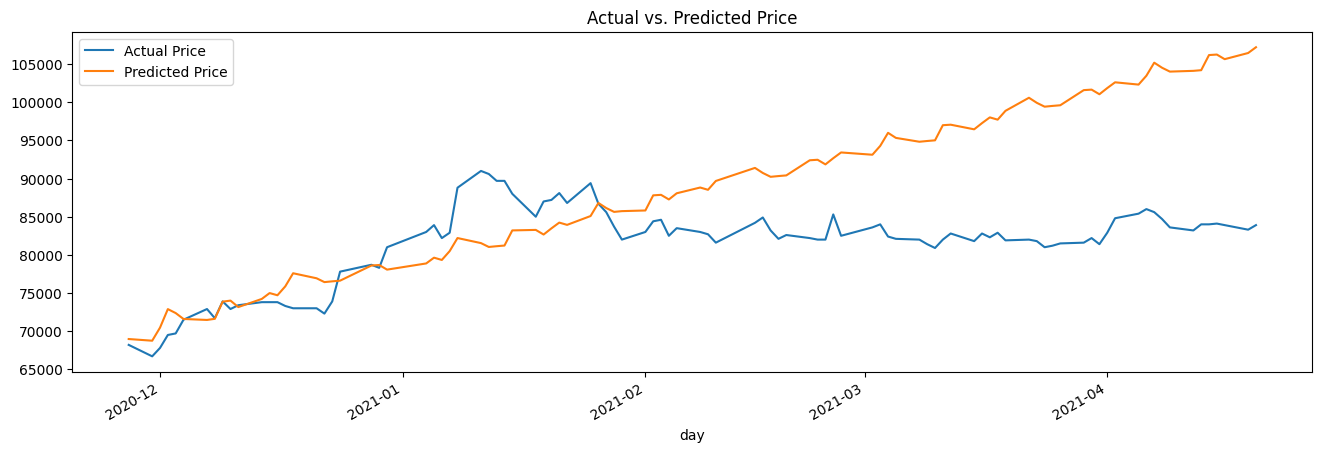

In [38]:
# 예측값 추정
prediction_series = pd.Series(prediction, index=test_data.index)

# 그리기
plt.figure(figsize=(16, 5))
test_data['price'].plot(label='Actual Price', legend=True)
prediction_series.plot(label='Predicted Price', legend=True)
plt.title('Actual vs. Predicted Price')
plt.show()

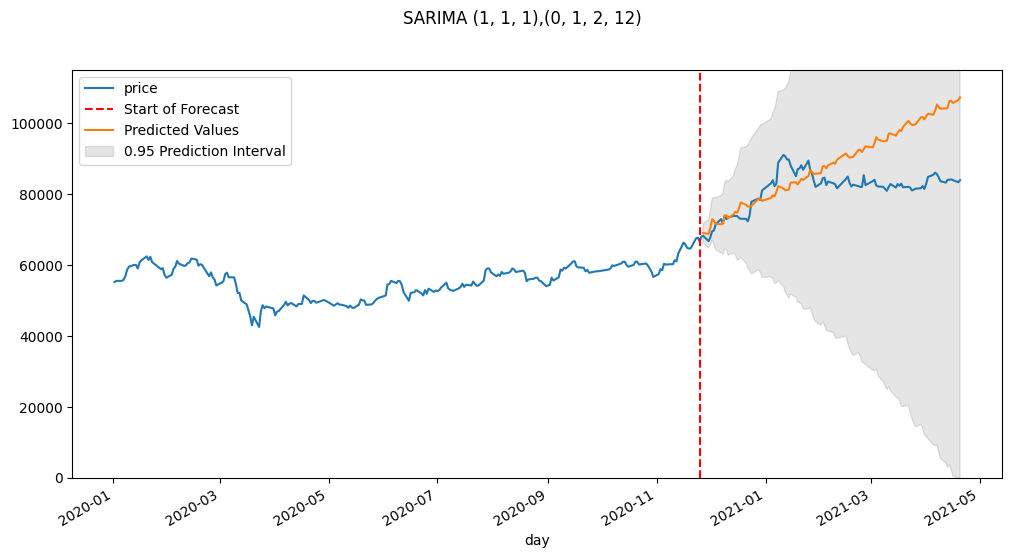

In [45]:
fig, ax = plt.subplots(figsize=(12, 6))

samsung_df.plot(ax=ax, label='Actual Data')
ax.vlines('2020-11-25', 0, 115000, linestyles='--', color='r', label='Start of Forecast')
ax.plot(predict_index, predicted_value, label='Predicted Values')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.set_ylim(0, 115000)
plt.suptitle(f"SARIMA {optimal[0][0][0]},{optimal[0][0][1]}")
ax.legend() # 범례 추가
plt.show()

`정확한 예측은 다소 어려운 부분이 있지만, 그럼에도 제공하는 Prediction interval 안에서 실제 test set이 포함하고 있는 것을 확인할 수 있다. `